# 13 - COLMAP Reconstruction and Camera Path Visualization


## Ziel
Dieses Notebook rekonstruiert den Kamerapfad aus den Trainingsbildern mit **COLMAP** (via `pycolmap`) und visualisiert:

1. Sparse SfM-Rekonstruktion
2. Rekonstruierte Kamerazentren als 3D-Pfad
3. 2D-Projektionen des Pfads
4. Optional: Similarity-Alignment auf die GT-Map-Pixel (`train_pos.csv`)

Hinweis: `pycolmap` ist die Python-Bindung zu COLMAP. Ein `colmap`-CLI-Binary ist nicht zwingend erforderlich.


In [1]:
from pathlib import Path
from time import perf_counter
from typing import Dict, List, Optional, Tuple
import shutil

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

import pycolmap


In [2]:
# Paths + runtime config
CANDIDATE_ROOTS = [Path.cwd(), Path.cwd().parent, Path('.'), Path('..')]
PROJECT_ROOT = None
_seen = set()
for cand in CANDIDATE_ROOTS:
    try:
        root = cand.resolve()
    except Exception:
        continue
    k = str(root)
    if k in _seen:
        continue
    _seen.add(k)
    if (root / 'data' / 'data').exists():
        PROJECT_ROOT = root
        break
if PROJECT_ROOT is None:
    raise FileNotFoundError('Could not find project root containing data/data.')

DATA_ROOT = PROJECT_ROOT / 'data' / 'data'
TRAIN_DIR = DATA_ROOT / 'train_data'
TRAIN_IMG_DIR = TRAIN_DIR / 'train_images'
TRAIN_POS_CSV = TRAIN_DIR / 'train_pos.csv'
TRAIN_CAM_CSV = TRAIN_DIR / 'train_cam.csv'

BUILD_ROOT = PROJECT_ROOT / 'build' / 'colmap_reconstruction'
RECON_NAME = 'train_seq_stable'
RECON_DIR = BUILD_ROOT / RECON_NAME
DB_PATH = RECON_DIR / 'database.db'
SPARSE_DIR = RECON_DIR / 'sparse'
BEST_MODEL_DIR = RECON_DIR / 'best_model'
PATH_CSV = RECON_DIR / 'camera_path.csv'
IMAGE_LIST_PATH = RECON_DIR / 'image_list.txt'

# Reset workspace if needed
RESET_WORKSPACE = False

# Stability profile
# - safe: recommended for WSL / unstable kernels
# - balanced: medium load
# - full: highest quality / highest memory
PROFILE = 'safe'  # ['safe', 'balanced', 'full']

# Image selection from training set
IMAGE_ID_MIN = None
IMAGE_ID_MAX = None
IMAGE_STEP = 1
MAX_IMAGES = None

# COLMAP settings
CAMERA_MODE = 'PER_IMAGE'   # ['AUTO', 'SINGLE', 'PER_FOLDER', 'PER_IMAGE']
CAMERA_MODEL = 'PINHOLE'
USE_KNOWN_INTRINSICS = True

MATCHER_MODE = 'sequential'  # ['sequential', 'exhaustive']
SEQUENTIAL_OVERLAP = 10
SEQUENTIAL_QUADRATIC_OVERLAP = True

# CUDA policy (fallback enabled)
USE_GPU = True
REQUIRE_CUDA = False
ALLOW_CPU_FALLBACK = True

# Thread control: lower this if kernel becomes unstable
NUM_THREADS = 6

# Feature/matching defaults (can be overridden by profile)
MAX_IMAGE_SIZE = 2000
SIFT_MAX_NUM_FEATURES = 8000
SIFT_PEAK_THRESHOLD = 0.006
SIFT_EDGE_THRESHOLD = 12.0

MATCH_MAX_NUM_MATCHES = 40000
MATCH_GUIDED = True
MATCH_RATIO = 0.85
MATCH_CROSS_CHECK = True

TVG_MAX_ERROR = 4.0
TVG_MIN_INLIERS = 15

MAPPER_MIN_NUM_MATCHES = 15
MAPPER_MIN_MODEL_SIZE = 20
MAPPER_MULTIPLE_MODELS = False
REFINE_FOCAL = True
REFINE_PRINCIPAL_POINT = False
REFINE_EXTRA_PARAMS = True


def apply_profile(profile: str):
    global MAX_IMAGES, MAX_IMAGE_SIZE, SIFT_MAX_NUM_FEATURES, MATCH_MAX_NUM_MATCHES
    global SEQUENTIAL_OVERLAP, NUM_THREADS

    p = str(profile).lower().strip()
    if p == 'safe':
        if MAX_IMAGES is None:
            MAX_IMAGES = 120
        MAX_IMAGE_SIZE = min(int(MAX_IMAGE_SIZE), 1400)
        SIFT_MAX_NUM_FEATURES = min(int(SIFT_MAX_NUM_FEATURES), 5000)
        MATCH_MAX_NUM_MATCHES = min(int(MATCH_MAX_NUM_MATCHES), 20000)
        SEQUENTIAL_OVERLAP = min(int(SEQUENTIAL_OVERLAP), 8)
        NUM_THREADS = min(int(NUM_THREADS), 4)
    elif p == 'balanced':
        if MAX_IMAGES is None:
            MAX_IMAGES = 220
        MAX_IMAGE_SIZE = min(int(MAX_IMAGE_SIZE), 1800)
        SIFT_MAX_NUM_FEATURES = min(int(SIFT_MAX_NUM_FEATURES), 8000)
        MATCH_MAX_NUM_MATCHES = min(int(MATCH_MAX_NUM_MATCHES), 35000)
        SEQUENTIAL_OVERLAP = min(int(SEQUENTIAL_OVERLAP), 12)
        NUM_THREADS = min(int(NUM_THREADS), 8)
    elif p == 'full':
        if MAX_IMAGES is None:
            MAX_IMAGES = None
    else:
        raise ValueError(f'Unknown PROFILE: {profile}')


apply_profile(PROFILE)

PYCOLMAP_HAS_CUDA = bool(getattr(pycolmap, 'has_cuda', False))
if USE_GPU and PYCOLMAP_HAS_CUDA:
    EFFECTIVE_USE_GPU = True
elif USE_GPU and not PYCOLMAP_HAS_CUDA:
    if REQUIRE_CUDA or not ALLOW_CPU_FALLBACK:
        raise RuntimeError(
            'CUDA requested, but pycolmap has no CUDA support (pycolmap.has_cuda == False). '            'Install CUDA-enabled pycolmap or disable REQUIRE_CUDA.'
        )
    EFFECTIVE_USE_GPU = False
else:
    EFFECTIVE_USE_GPU = False

DEVICE = pycolmap.Device.cuda if EFFECTIVE_USE_GPU else pycolmap.Device.cpu

print('project_root:', PROJECT_ROOT)
print('pycolmap version:', pycolmap.__version__)
print('pycolmap has_cuda:', PYCOLMAP_HAS_CUDA)
print('effective backend:', 'CUDA' if EFFECTIVE_USE_GPU else 'CPU')
print('profile:', PROFILE)
print('num_threads:', NUM_THREADS)
print('max_images:', MAX_IMAGES)
print('max_image_size:', MAX_IMAGE_SIZE)
print('sift_max_num_features:', SIFT_MAX_NUM_FEATURES)
print('match_max_num_matches:', MATCH_MAX_NUM_MATCHES)
print('recon_dir:', RECON_DIR)


project_root: /home/rupert/projects/gnss-denied-localization
pycolmap version: 3.13.0
pycolmap has_cuda: False
effective backend: CPU
profile: safe
num_threads: 4
max_images: 120
max_image_size: 1400
sift_max_num_features: 5000
match_max_num_matches: 20000
recon_dir: /home/rupert/projects/gnss-denied-localization/build/colmap_reconstruction/train_seq_stable


In [3]:
# Load metadata and build selected image list
train_pos_df = pd.read_csv(TRAIN_POS_CSV)
train_cam_df = pd.read_csv(TRAIN_CAM_CSV)

required_pos = {'id', 'x_pixel', 'y_pixel'}
required_cam = {'id', 'fx', 'fy', 'cx', 'cy'}
if not required_pos.issubset(set(train_pos_df.columns)):
    raise KeyError(f'train_pos missing columns: {required_pos - set(train_pos_df.columns)}')
if not required_cam.issubset(set(train_cam_df.columns)):
    raise KeyError(f'train_cam missing columns: {required_cam - set(train_cam_df.columns)}')

all_files = []
for p in sorted(TRAIN_IMG_DIR.iterdir()):
    if p.suffix.lower() not in {'.jpg', '.jpeg', '.png'}:
        continue
    try:
        img_id = int(p.stem)
    except Exception:
        continue
    all_files.append({'id': img_id, 'name': p.name, 'path': str(p)})
img_df = pd.DataFrame(all_files)
if len(img_df) == 0:
    raise RuntimeError(f'No images found in {TRAIN_IMG_DIR}')

meta_df = (
    img_df
    .merge(train_cam_df[['id', 'fx', 'fy', 'cx', 'cy']], on='id', how='left')
    .merge(train_pos_df[['id', 'x_pixel', 'y_pixel']], on='id', how='left')
    .sort_values('id')
    .reset_index(drop=True)
)

if IMAGE_ID_MIN is not None:
    meta_df = meta_df[meta_df['id'] >= int(IMAGE_ID_MIN)]
if IMAGE_ID_MAX is not None:
    meta_df = meta_df[meta_df['id'] <= int(IMAGE_ID_MAX)]

if int(IMAGE_STEP) > 1:
    meta_df = meta_df.iloc[::int(IMAGE_STEP)].copy()

if MAX_IMAGES is not None:
    meta_df = meta_df.head(int(MAX_IMAGES)).copy()

meta_df = meta_df.reset_index(drop=True)
if len(meta_df) < 2:
    raise RuntimeError('Need at least 2 selected images for reconstruction.')

selected_names = meta_df['name'].tolist()
selected_ids = meta_df['id'].astype(int).tolist()

print('selected images:', len(selected_names))
print('id range:', (min(selected_ids), max(selected_ids)))
display(meta_df.head(20))


selected images: 120
id range: (13, 2598)


,id,name,path,fx,fy,cx,cy,x_pixel,y_pixel
0,13,0013.JPG,/home/rupert/projects/gnss-denied-localization...,6591.64847,6620.211674,4000.0,3000.0,2572.737997,286.932310
1,14,0014.JPG,/home/rupert/projects/gnss-denied-localization...,6591.64847,6620.211674,4000.0,3000.0,2584.838216,569.575778
2,15,0015.JPG,/home/rupert/projects/gnss-denied-localization...,6591.64847,6620.211674,4000.0,3000.0,2596.241078,852.752558
3,16,0016.JPG,/home/rupert/projects/gnss-denied-localization...,6591.64847,6620.211674,4000.0,3000.0,2606.549987,1134.367249
4,17,0017.JPG,/home/rupert/projects/gnss-denied-localization...,6591.64847,6620.211674,4000.0,3000.0,2616.776583,1416.000406
5,18,0018.JPG,/home/rupert/projects/gnss-denied-localization...,6591.64847,6620.211674,4000.0,3000.0,2628.009666,1698.616847
6,19,0019.JPG,/home/rupert/projects/gnss-denied-localization...,6591.64847,6620.211674,4000.0,3000.0,2310.170891,1888.884916
7,20,0020.JPG,/home/rupert/projects/gnss-denied-localization...,6591.64847,6620.211674,4000.0,3000.0,2300.893728,1596.091679
8,21,0021.JPG,/home/rupert/projects/gnss-denied-localization...,6591.64847,6620.211674,4000.0,3000.0,2289.151019,1314.752983
9,22,0022.JPG,/home/rupert/projects/gnss-denied-localization...,6591.64847,6620.211674,4000.0,3000.0,2278.064229,1032.964801


In [4]:
# Prepare reconstruction workspace
if RESET_WORKSPACE and RECON_DIR.exists():
    shutil.rmtree(RECON_DIR)

RECON_DIR.mkdir(parents=True, exist_ok=True)
SPARSE_DIR.mkdir(parents=True, exist_ok=True)
BEST_MODEL_DIR.mkdir(parents=True, exist_ok=True)

if DB_PATH.exists():
    DB_PATH.unlink()

IMAGE_LIST_PATH.write_text('\n'.join(selected_names) + '\n', encoding='utf-8')

print('workspace ready:', RECON_DIR)
print('database path:', DB_PATH)
print('image list path:', IMAGE_LIST_PATH)


workspace ready: /home/rupert/projects/gnss-denied-localization/build/colmap_reconstruction/train_seq_stable
database path: /home/rupert/projects/gnss-denied-localization/build/colmap_reconstruction/train_seq_stable/database.db
image list path: /home/rupert/projects/gnss-denied-localization/build/colmap_reconstruction/train_seq_stable/image_list.txt


In [5]:
# Run COLMAP (pycolmap)

def build_reader_options(meta_df: pd.DataFrame) -> pycolmap.ImageReaderOptions:
    ro = pycolmap.ImageReaderOptions()
    ro.camera_model = str(CAMERA_MODEL)

    if USE_KNOWN_INTRINSICS:
        # robust median intrinsics from selected set
        fx = float(meta_df['fx'].dropna().median())
        fy = float(meta_df['fy'].dropna().median())
        cx = float(meta_df['cx'].dropna().median())
        cy = float(meta_df['cy'].dropna().median())
        ro.camera_params = f'{fx},{fy},{cx},{cy}'
        print('Using known intrinsics (median):', ro.camera_params)

    return ro


def _apply_num_threads(opts, n_threads: int):
    if hasattr(opts, 'num_threads'):
        opts.num_threads = int(n_threads)


def run_colmap_pipeline(selected_names: List[str], meta_df: pd.DataFrame):
    reader_options = build_reader_options(meta_df)

    runtime_use_gpu = bool(EFFECTIVE_USE_GPU)
    runtime_device = pycolmap.Device.cuda if runtime_use_gpu else pycolmap.Device.cpu

    # 1) feature extraction
    extraction_options = pycolmap.FeatureExtractionOptions()
    extraction_options.max_image_size = int(MAX_IMAGE_SIZE)
    extraction_options.use_gpu = bool(runtime_use_gpu)
    extraction_options.sift.max_num_features = int(SIFT_MAX_NUM_FEATURES)
    extraction_options.sift.peak_threshold = float(SIFT_PEAK_THRESHOLD)
    extraction_options.sift.edge_threshold = float(SIFT_EDGE_THRESHOLD)
    _apply_num_threads(extraction_options, int(NUM_THREADS))

    camera_mode_enum = getattr(pycolmap.CameraMode, str(CAMERA_MODE).upper())

    def _run_extract(device, use_gpu):
        extraction_options.use_gpu = bool(use_gpu)
        pycolmap.extract_features(
            database_path=str(DB_PATH),
            image_path=str(TRAIN_IMG_DIR),
            image_names=selected_names,
            camera_mode=camera_mode_enum,
            camera_model=str(CAMERA_MODEL),
            reader_options=reader_options,
            extraction_options=extraction_options,
            device=device,
        )

    t0 = perf_counter()
    try:
        _run_extract(runtime_device, runtime_use_gpu)
    except Exception as e:
        if runtime_use_gpu and ALLOW_CPU_FALLBACK:
            print(f'GPU feature extraction failed ({e}). Retrying on CPU...')
            runtime_use_gpu = False
            runtime_device = pycolmap.Device.cpu
            _run_extract(runtime_device, False)
        else:
            raise
    print(f'Feature extraction done in {perf_counter() - t0:.1f}s | backend={"CUDA" if runtime_use_gpu else "CPU"}')

    # 2) matching
    matching_options = pycolmap.FeatureMatchingOptions()
    matching_options.use_gpu = bool(runtime_use_gpu)
    matching_options.max_num_matches = int(MATCH_MAX_NUM_MATCHES)
    matching_options.guided_matching = bool(MATCH_GUIDED)
    matching_options.sift.max_ratio = float(MATCH_RATIO)
    matching_options.sift.cross_check = bool(MATCH_CROSS_CHECK)
    _apply_num_threads(matching_options, int(NUM_THREADS))

    verification_options = pycolmap.TwoViewGeometryOptions()
    verification_options.min_num_inliers = int(TVG_MIN_INLIERS)
    verification_options.ransac.max_error = float(TVG_MAX_ERROR)

    t1 = perf_counter()
    if str(MATCHER_MODE).lower() == 'sequential':
        pairing_options = pycolmap.SequentialPairingOptions()
        pairing_options.overlap = int(SEQUENTIAL_OVERLAP)
        pairing_options.quadratic_overlap = bool(SEQUENTIAL_QUADRATIC_OVERLAP)
        _apply_num_threads(pairing_options, int(NUM_THREADS))
        pycolmap.match_sequential(
            database_path=str(DB_PATH),
            matching_options=matching_options,
            pairing_options=pairing_options,
            verification_options=verification_options,
            device=runtime_device,
        )
    elif str(MATCHER_MODE).lower() == 'exhaustive':
        pycolmap.match_exhaustive(
            database_path=str(DB_PATH),
            matching_options=matching_options,
            verification_options=verification_options,
            device=runtime_device,
        )
    else:
        raise ValueError(f'Unknown MATCHER_MODE: {MATCHER_MODE}')
    print(f'Matching ({MATCHER_MODE}) done in {perf_counter() - t1:.1f}s | backend={"CUDA" if runtime_use_gpu else "CPU"}')

    # 3) mapping
    mapper_options = pycolmap.IncrementalPipelineOptions()
    mapper_options.min_num_matches = int(MAPPER_MIN_NUM_MATCHES)
    mapper_options.multiple_models = bool(MAPPER_MULTIPLE_MODELS)
    mapper_options.min_model_size = int(MAPPER_MIN_MODEL_SIZE)
    mapper_options.ba_refine_focal_length = bool(REFINE_FOCAL)
    mapper_options.ba_refine_principal_point = bool(REFINE_PRINCIPAL_POINT)
    mapper_options.ba_refine_extra_params = bool(REFINE_EXTRA_PARAMS)
    mapper_options.image_names = selected_names
    _apply_num_threads(mapper_options, int(NUM_THREADS))

    t2 = perf_counter()
    recons = pycolmap.incremental_mapping(
        database_path=str(DB_PATH),
        image_path=str(TRAIN_IMG_DIR),
        output_path=str(SPARSE_DIR),
        options=mapper_options,
    )
    print(f'Mapping done in {perf_counter() - t2:.1f}s')

    return recons


reconstructions = run_colmap_pipeline(selected_names, meta_df)

if len(reconstructions) == 0:
    raise RuntimeError('COLMAP did not produce any reconstruction model.')

print('reconstructed models:', list(reconstructions.keys()))


Using known intrinsics (median): 6684.558335197985,6719.3640403175095,4000.0,3000.0


I20260214 15:44:51.486407 132349664687680 misc.cc:44] 
Feature extraction
I20260214 15:44:51.486988 132349551441472 sift.cc:726] Creating SIFT CPU feature extractor
I20260214 15:44:51.487043 132349543048768 sift.cc:726] Creating SIFT CPU feature extractor
I20260214 15:44:51.487073 132349534656064 sift.cc:726] Creating SIFT CPU feature extractor
I20260214 15:44:51.487168 132349526263360 sift.cc:726] Creating SIFT CPU feature extractor
I20260214 15:44:55.487312 132349517870656 feature_extraction.cc:260] Processed file [1/120]
I20260214 15:44:55.487378 132349517870656 feature_extraction.cc:263]   Name:            0013.JPG
I20260214 15:44:55.487387 132349517870656 feature_extraction.cc:272]   Dimensions:      8004 x 6001
I20260214 15:44:55.487391 132349517870656 feature_extraction.cc:275]   Camera:          #1 - PINHOLE
I20260214 15:44:55.487396 132349517870656 feature_extraction.cc:278]   Focal Length:    6701.96px (Prior)
I20260214 15:44:55.487408 132349517870656 feature_extraction.cc:28

Feature extraction done in 97.8s | backend=CPU


I20260214 15:46:38.828745 132349664687680 feature_matching.cc:117] in 3.681s
I20260214 15:46:38.828793 132349664687680 pairing.cc:470] Processing image [2/120]
I20260214 15:46:42.860094 132349664687680 feature_matching.cc:117] in 4.031s
I20260214 15:46:42.860149 132349664687680 pairing.cc:470] Processing image [3/120]
I20260214 15:46:46.935333 132349664687680 feature_matching.cc:117] in 4.075s
I20260214 15:46:46.935379 132349664687680 pairing.cc:470] Processing image [4/120]
I20260214 15:46:50.467167 132349664687680 feature_matching.cc:117] in 3.532s
I20260214 15:46:50.467212 132349664687680 pairing.cc:470] Processing image [5/120]
I20260214 15:46:54.490150 132349664687680 feature_matching.cc:117] in 4.023s
I20260214 15:46:54.490224 132349664687680 pairing.cc:470] Processing image [6/120]
I20260214 15:46:58.198907 132349664687680 feature_matching.cc:117] in 3.709s
I20260214 15:46:58.198995 132349664687680 pairing.cc:470] Processing image [7/120]
I20260214 15:47:03.269896 13234966468768

Matching (sequential) done in 355.6s | backend=CPU


I20260214 15:52:54.045361 132353575653376 database_cache.cc:277]  in 0.112s (ignored 0)
I20260214 15:52:54.045954 132353575653376 timer.cc:90] Elapsed time: 0.003 [minutes]
I20260214 15:52:54.058527 132353575653376 incremental_pipeline.cc:311] Finding good initial image pair
I20260214 15:52:54.122782 132353575653376 incremental_pipeline.cc:335] Registering initial image pair #82 and #84
I20260214 15:52:54.132628 132353575653376 incremental_pipeline.cc:349] Global bundle adjustment
I20260214 15:52:55.683918 132353575653376 incremental_pipeline.cc:439] Registering image #83 (num_reg_frames=2)
I20260214 15:52:55.683963 132353575653376 incremental_pipeline.cc:442] => Image sees 3093 / 9081 points
I20260214 15:52:57.122118 132353575653376 incremental_pipeline.cc:43] Retriangulation and Global bundle adjustment
I20260214 15:52:59.346066 132353575653376 incremental_pipeline.cc:439] Registering image #81 (num_reg_frames=3)
I20260214 15:52:59.346106 132353575653376 incremental_pipeline.cc:442] 

Mapping done in 479.2s
reconstructed models: [0]


In [6]:
# Pick best model (largest registered image count)

def num_reg_images_safe(rec: pycolmap.Reconstruction) -> int:
    try:
        return int(rec.num_reg_images())
    except Exception:
        return int(len(rec.images))

best_model_id = max(reconstructions.keys(), key=lambda k: num_reg_images_safe(reconstructions[k]))
recon = reconstructions[best_model_id]

# Save best model snapshot
if BEST_MODEL_DIR.exists():
    shutil.rmtree(BEST_MODEL_DIR)
BEST_MODEL_DIR.mkdir(parents=True, exist_ok=True)
recon.write(str(BEST_MODEL_DIR))

num_imgs = num_reg_images_safe(recon)
num_pts = int(len(recon.points3D))
print('best_model_id:', best_model_id)
print('registered_images:', num_imgs)
print('points3D:', num_pts)
print('model saved to:', BEST_MODEL_DIR)
print(recon.summary())


best_model_id: 0
registered_images: 120
points3D: 114103
model saved to: /home/rupert/projects/gnss-denied-localization/build/colmap_reconstruction/train_seq_stable/best_model
Reconstruction:
	num_rigs = 120
	num_cameras = 120
	num_frames = 120
	num_reg_frames = 120
	num_images = 120
	num_points3D = 114103
	num_observations = 457376
	mean_track_length = 4.00845
	mean_observations_per_image = 3811.47
	mean_reprojection_error = 1.04664


In [7]:
# Extract camera path from reconstruction and save CSV
rows = []
for image_id, img in recon.images.items():
    if not img.has_pose:
        continue

    c = np.asarray(img.projection_center(), dtype=np.float64).reshape(-1)
    name = str(img.name)
    try:
        frame_id = int(Path(name).stem)
    except Exception:
        frame_id = -1

    rows.append({
        'image_id': int(image_id),
        'name': name,
        'frame_id': int(frame_id),
        'cx': float(c[0]),
        'cy': float(c[1]),
        'cz': float(c[2]),
    })

path_df = pd.DataFrame(rows)
if len(path_df) == 0:
    raise RuntimeError('No registered camera poses in selected reconstruction.')

# sort by frame id if parseable, else by COLMAP image_id
if (path_df['frame_id'] >= 0).sum() > 0:
    path_df = path_df.sort_values(['frame_id', 'image_id']).reset_index(drop=True)
else:
    path_df = path_df.sort_values('image_id').reset_index(drop=True)

path_df.to_csv(PATH_CSV, index=False)
print('camera path CSV:', PATH_CSV)
display(path_df.head(20))
print('path points:', len(path_df))


camera path CSV: /home/rupert/projects/gnss-denied-localization/build/colmap_reconstruction/train_seq_stable/camera_path.csv


,image_id,name,frame_id,cx,cy,cz
0,1,0013.JPG,13,-1.935971,4.279754,-0.152647
1,2,0014.JPG,14,-2.016030,2.553989,-0.593909
2,3,0015.JPG,15,-2.129095,0.798612,-0.568000
3,4,0016.JPG,16,-2.254057,-0.979550,-0.240095
4,5,0017.JPG,17,-2.362837,-2.734633,-0.260027
5,6,0018.JPG,18,-2.477435,-4.509290,-0.054047
6,7,0019.JPG,19,-0.552337,-5.433339,-0.211316
7,8,0020.JPG,20,-0.437048,-3.639151,-0.189523
8,9,0021.JPG,21,-0.322188,-1.889856,-0.244245
9,10,0022.JPG,22,-0.209636,-0.135013,-0.460358


path points: 120


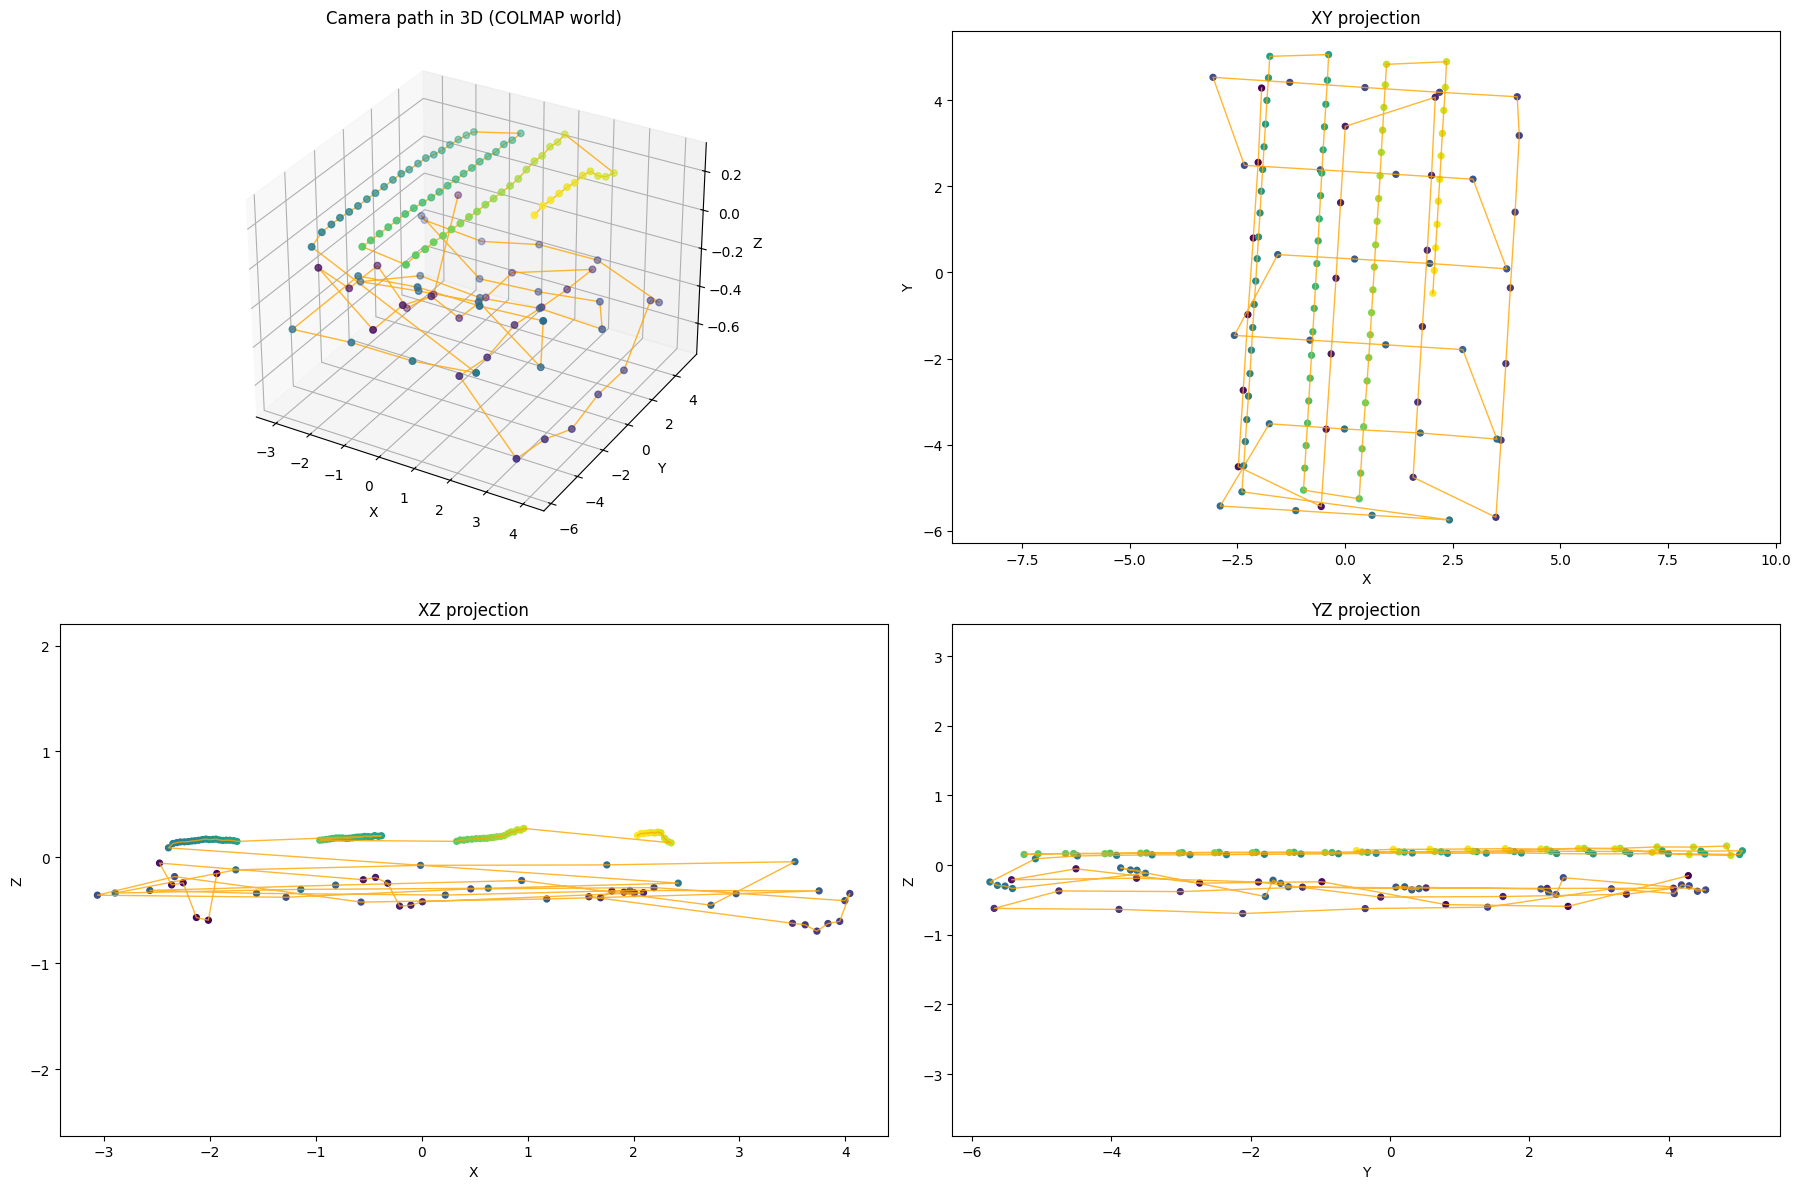

In [8]:
# Visualize camera path: 3D + 2D projections
X = path_df[['cx', 'cy', 'cz']].to_numpy(dtype=np.float64)
order = np.arange(len(path_df))

fig = plt.figure(figsize=(18, 12))

ax3d = fig.add_subplot(2, 2, 1, projection='3d')
ax3d.scatter(X[:, 0], X[:, 1], X[:, 2], c=order, cmap='viridis', s=22)
ax3d.plot(X[:, 0], X[:, 1], X[:, 2], color='orange', linewidth=1.0, alpha=0.8)
ax3d.set_title('Camera path in 3D (COLMAP world)')
ax3d.set_xlabel('X')
ax3d.set_ylabel('Y')
ax3d.set_zlabel('Z')

ax_xy = fig.add_subplot(2, 2, 2)
ax_xy.scatter(X[:, 0], X[:, 1], c=order, cmap='viridis', s=18)
ax_xy.plot(X[:, 0], X[:, 1], color='orange', linewidth=1.0, alpha=0.8)
ax_xy.set_title('XY projection')
ax_xy.set_xlabel('X')
ax_xy.set_ylabel('Y')
ax_xy.axis('equal')

ax_xz = fig.add_subplot(2, 2, 3)
ax_xz.scatter(X[:, 0], X[:, 2], c=order, cmap='viridis', s=18)
ax_xz.plot(X[:, 0], X[:, 2], color='orange', linewidth=1.0, alpha=0.8)
ax_xz.set_title('XZ projection')
ax_xz.set_xlabel('X')
ax_xz.set_ylabel('Z')
ax_xz.axis('equal')

ax_yz = fig.add_subplot(2, 2, 4)
ax_yz.scatter(X[:, 1], X[:, 2], c=order, cmap='viridis', s=18)
ax_yz.plot(X[:, 1], X[:, 2], color='orange', linewidth=1.0, alpha=0.8)
ax_yz.set_title('YZ projection')
ax_yz.set_xlabel('Y')
ax_yz.set_ylabel('Z')
ax_yz.axis('equal')

plt.tight_layout()
plt.show()


alignment points: 120 | RMSE: 16.02 px


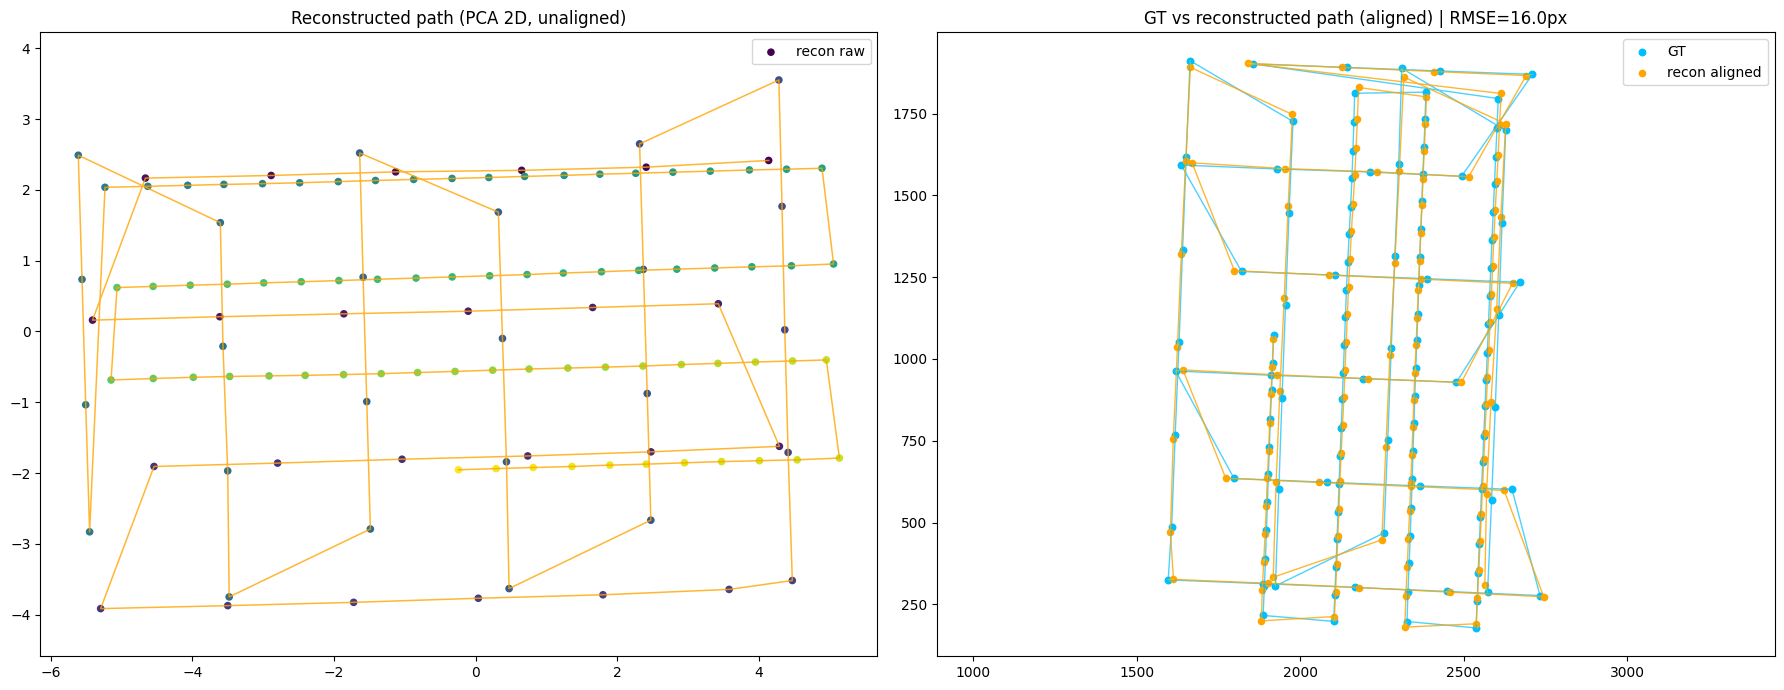

In [9]:
# Optional: align reconstructed path to GT map pixels (2D similarity)

def umeyama_similarity_2d(src: np.ndarray, dst: np.ndarray) -> Tuple[float, np.ndarray, np.ndarray]:
    # src,dst: Nx2, solves dst ~= s * src @ R^T + t
    src = np.asarray(src, dtype=np.float64)
    dst = np.asarray(dst, dtype=np.float64)
    if src.shape != dst.shape or src.shape[0] < 2:
        raise ValueError('Need matching Nx2 points with N>=2')

    mu_s = src.mean(axis=0)
    mu_d = dst.mean(axis=0)

    X = src - mu_s
    Y = dst - mu_d

    cov = (Y.T @ X) / float(src.shape[0])
    U, S, Vt = np.linalg.svd(cov)
    R = U @ Vt
    if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = U @ Vt

    var_s = np.mean(np.sum(X * X, axis=1))
    if var_s < 1e-12:
        raise ValueError('Degenerate source variance')

    scale = float(np.sum(S) / var_s)
    t = mu_d - scale * (R @ mu_s)
    return scale, R, t


def pca_2d(points3d: np.ndarray) -> np.ndarray:
    X = np.asarray(points3d, dtype=np.float64)
    Xc = X - X.mean(axis=0)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    basis = Vt[:2, :]  # 2x3
    Y = Xc @ basis.T   # Nx2
    return Y


gt_df = train_pos_df[['id', 'x_pixel', 'y_pixel']].copy()
merge_df = path_df.merge(gt_df, left_on='frame_id', right_on='id', how='inner')

if len(merge_df) < 3:
    print('Not enough overlap with GT for alignment (need >=3).')
else:
    rec3d = merge_df[['cx', 'cy', 'cz']].to_numpy(dtype=np.float64)
    rec2d = pca_2d(rec3d)
    gt2d = merge_df[['x_pixel', 'y_pixel']].to_numpy(dtype=np.float64)

    s, R, t = umeyama_similarity_2d(rec2d, gt2d)
    rec2d_aligned = (s * (rec2d @ R.T)) + t

    rmse = float(np.sqrt(np.mean(np.sum((rec2d_aligned - gt2d) ** 2, axis=1))))
    print(f'alignment points: {len(merge_df)} | RMSE: {rmse:.2f} px')

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    axes[0].scatter(rec2d[:, 0], rec2d[:, 1], c=np.arange(len(rec2d)), cmap='viridis', s=20, label='recon raw')
    axes[0].plot(rec2d[:, 0], rec2d[:, 1], color='orange', linewidth=1.1, alpha=0.8)
    axes[0].set_title('Reconstructed path (PCA 2D, unaligned)')
    axes[0].axis('equal')
    axes[0].legend(loc='best')

    axes[1].scatter(gt2d[:, 0], gt2d[:, 1], c='deepskyblue', s=22, label='GT')
    axes[1].plot(gt2d[:, 0], gt2d[:, 1], color='deepskyblue', linewidth=1.0, alpha=0.7)
    axes[1].scatter(rec2d_aligned[:, 0], rec2d_aligned[:, 1], c='orange', s=20, label='recon aligned')
    axes[1].plot(rec2d_aligned[:, 0], rec2d_aligned[:, 1], color='orange', linewidth=1.0, alpha=0.8)

    for _, r in merge_df.iloc[::max(1, len(merge_df)//40)].iterrows():
        idx = int(r.name - merge_df.index.min())
        axes[1].plot(
            [gt2d[idx, 0], rec2d_aligned[idx, 0]],
            [gt2d[idx, 1], rec2d_aligned[idx, 1]],
            color='yellow', alpha=0.35, linewidth=0.8,
        )

    axes[1].set_title(f'GT vs reconstructed path (aligned) | RMSE={rmse:.1f}px')
    axes[1].axis('equal')
    axes[1].legend(loc='best')

    plt.tight_layout()
    plt.show()


In [10]:
# Optional: export model also as text for inspection
EXPORT_TEXT_MODEL = True
TEXT_MODEL_DIR = RECON_DIR / 'best_model_txt'

if EXPORT_TEXT_MODEL:
    if TEXT_MODEL_DIR.exists():
        shutil.rmtree(TEXT_MODEL_DIR)
    TEXT_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    recon.write_text(str(TEXT_MODEL_DIR))
    print('text model exported to:', TEXT_MODEL_DIR)

print('Done.')


text model exported to: /home/rupert/projects/gnss-denied-localization/build/colmap_reconstruction/train_seq_stable/best_model_txt
Done.


## COLMAP Submission (Train + Test)
Dieser Block baut ein **gemeinsames COLMAP-Modell** aus `train_data` + `test_data`,
lernt aus den registrierten Train-Bildern die Abbildung **COLMAP-Welt -> map.png Pixel**
und erzeugt daraus `submission.csv` für alle Test-IDs.


In [ ]:
# Submission config + metadata (train + test)
TEST_DIR = DATA_ROOT / 'test_data'
TEST_IMG_DIR = TEST_DIR / 'test_images'
TEST_CAM_CSV = TEST_DIR / 'test_cam.csv'
MAP_PATH = DATA_ROOT / 'map.png'

SUBMISSION_RECON_DIR = RECON_DIR / 'submission_joint'
SUBMISSION_DB_PATH = SUBMISSION_RECON_DIR / 'database.db'
SUBMISSION_SPARSE_DIR = SUBMISSION_RECON_DIR / 'sparse'
SUBMISSION_MODEL_DIR = SUBMISSION_RECON_DIR / 'best_model'
SUBMISSION_CSV_PATH = RECON_DIR / 'submission.csv'

RESET_SUBMISSION_WORKSPACE = True
SUBMISSION_MAX_IMAGES = None  # keep None for full train+test run
SUBMISSION_MATCHER_MODE = 'sequential'  # ['sequential', 'exhaustive']
SUBMISSION_CAMERA_MODE = 'PER_IMAGE'   # robust for mixed image dimensions
SUBMISSION_OVERLAP = max(int(SEQUENTIAL_OVERLAP), 10)

ALIGN_RANSAC_REPROJ_PX = 35.0
ALIGN_MAX_ITERS = 20000
ALIGN_CONFIDENCE = 0.999

train_cam_full = pd.read_csv(TRAIN_CAM_CSV)
test_cam_full = pd.read_csv(TEST_CAM_CSV)
train_gt_full = pd.read_csv(TRAIN_POS_CSV)

required_cam = {'id', 'fx', 'fy', 'cx', 'cy'}
for name, df in [('train_cam', train_cam_full), ('test_cam', test_cam_full)]:
    if not required_cam.issubset(set(df.columns)):
        raise KeyError(f'{name} missing columns: {required_cam - set(df.columns)}')

required_gt = {'id', 'x_pixel', 'y_pixel'}
if not required_gt.issubset(set(train_gt_full.columns)):
    raise KeyError(f'train_pos missing columns: {required_gt - set(train_gt_full.columns)}')


def _collect_images(img_dir: Path, split: str) -> pd.DataFrame:
    rows = []
    for p in sorted(img_dir.iterdir()):
        if p.suffix.lower() not in {'.jpg', '.jpeg', '.png'}:
            continue
        try:
            img_id = int(p.stem)
        except Exception:
            continue
        rel_name = str(p.relative_to(DATA_ROOT)).replace('\\', '/')
        rows.append({'id': int(img_id), 'name': rel_name, 'split': split})
    return pd.DataFrame(rows)

train_img_df = _collect_images(TRAIN_IMG_DIR, split='train')
test_img_df = _collect_images(TEST_IMG_DIR, split='test')
if len(train_img_df) == 0 or len(test_img_df) == 0:
    raise RuntimeError('Missing train or test images.')

cam_full = pd.concat([
    train_cam_full[['id', 'fx', 'fy', 'cx', 'cy']].copy(),
    test_cam_full[['id', 'fx', 'fy', 'cx', 'cy']].copy(),
], ignore_index=True).drop_duplicates(subset=['id'], keep='first')

combo_df = pd.concat([train_img_df, test_img_df], ignore_index=True)
combo_df = combo_df.merge(cam_full, on='id', how='left')
combo_df = combo_df.sort_values(['id', 'split']).reset_index(drop=True)

if SUBMISSION_MAX_IMAGES is not None:
    combo_df = combo_df.head(int(SUBMISSION_MAX_IMAGES)).copy()

if len(combo_df) < 2:
    raise RuntimeError('Need at least 2 images for COLMAP.')

combo_names = combo_df['name'].tolist()
combo_meta = combo_df.copy()

if RESET_SUBMISSION_WORKSPACE and SUBMISSION_RECON_DIR.exists():
    shutil.rmtree(SUBMISSION_RECON_DIR)

SUBMISSION_RECON_DIR.mkdir(parents=True, exist_ok=True)
SUBMISSION_SPARSE_DIR.mkdir(parents=True, exist_ok=True)
SUBMISSION_MODEL_DIR.mkdir(parents=True, exist_ok=True)

if SUBMISSION_DB_PATH.exists():
    SUBMISSION_DB_PATH.unlink()

print('submission workspace:', SUBMISSION_RECON_DIR)
print('images total:', len(combo_df), '| train:', int((combo_df['split'] == 'train').sum()), '| test:', int((combo_df['split'] == 'test').sum()))
print('id range:', int(combo_df['id'].min()), '->', int(combo_df['id'].max()))
display(combo_df.head(10))


submission workspace: /home/rupert/projects/gnss-denied-localization/build/colmap_reconstruction/train_seq_stable/submission_joint
images total: 441 | train: 305 | test: 136
id range: 1 -> 2836


,id,name,split,fx,fy,cx,cy
0,1,test_data/test_images/0001.JPG,test,6591.64847,6620.211674,4000.0,3000.0
1,2,test_data/test_images/0002.JPG,test,6591.64847,6620.211674,4000.0,3000.0
2,3,test_data/test_images/0003.JPG,test,6591.64847,6620.211674,4000.0,3000.0
3,4,test_data/test_images/0004.JPG,test,6591.64847,6620.211674,4000.0,3000.0
4,5,test_data/test_images/0005.JPG,test,6591.64847,6620.211674,4000.0,3000.0
5,6,test_data/test_images/0006.JPG,test,6591.64847,6620.211674,4000.0,3000.0
6,7,test_data/test_images/0007.JPG,test,6591.64847,6620.211674,4000.0,3000.0
7,8,test_data/test_images/0008.JPG,test,6591.64847,6620.211674,4000.0,3000.0
8,9,test_data/test_images/0009.JPG,test,6591.64847,6620.211674,4000.0,3000.0
9,10,test_data/test_images/0010.JPG,test,6591.64847,6620.211674,4000.0,3000.0


: 

In [ ]:
# Run COLMAP on combined train+test set

def build_reader_options_from_cam(cam_df: pd.DataFrame) -> pycolmap.ImageReaderOptions:
    ro = pycolmap.ImageReaderOptions()
    ro.camera_model = str(CAMERA_MODEL)
    if USE_KNOWN_INTRINSICS:
        fx = float(cam_df['fx'].dropna().median())
        fy = float(cam_df['fy'].dropna().median())
        cx = float(cam_df['cx'].dropna().median())
        cy = float(cam_df['cy'].dropna().median())
        ro.camera_params = f'{fx},{fy},{cx},{cy}'
        print('Using known intrinsics (median train+test):', ro.camera_params)
    return ro


def run_colmap_pipeline_generic(
    database_path: Path,
    image_path: Path,
    image_names: List[str],
    output_sparse_dir: Path,
    cam_meta_df: pd.DataFrame,
    matcher_mode: str = 'sequential',
    camera_mode: str = 'PER_IMAGE',
    sequential_overlap: int = 10,
):
    reader_options = build_reader_options_from_cam(cam_meta_df)

    runtime_use_gpu = bool(EFFECTIVE_USE_GPU)
    runtime_device = pycolmap.Device.cuda if runtime_use_gpu else pycolmap.Device.cpu

    extraction_options = pycolmap.FeatureExtractionOptions()
    extraction_options.max_image_size = int(MAX_IMAGE_SIZE)
    extraction_options.use_gpu = bool(runtime_use_gpu)
    extraction_options.sift.max_num_features = int(SIFT_MAX_NUM_FEATURES)
    extraction_options.sift.peak_threshold = float(SIFT_PEAK_THRESHOLD)
    extraction_options.sift.edge_threshold = float(SIFT_EDGE_THRESHOLD)
    _apply_num_threads(extraction_options, int(NUM_THREADS))

    camera_mode_enum = getattr(pycolmap.CameraMode, str(camera_mode).upper())

    def _run_extract(device, use_gpu):
        extraction_options.use_gpu = bool(use_gpu)
        pycolmap.extract_features(
            database_path=str(database_path),
            image_path=str(image_path),
            image_names=image_names,
            camera_mode=camera_mode_enum,
            camera_model=str(CAMERA_MODEL),
            reader_options=reader_options,
            extraction_options=extraction_options,
            device=device,
        )

    t0 = perf_counter()
    try:
        _run_extract(runtime_device, runtime_use_gpu)
    except Exception as e:
        if runtime_use_gpu and ALLOW_CPU_FALLBACK:
            print(f'GPU feature extraction failed ({e}). Retrying on CPU...')
            runtime_use_gpu = False
            runtime_device = pycolmap.Device.cpu
            _run_extract(runtime_device, False)
        else:
            raise
    print(f'Feature extraction done in {perf_counter() - t0:.1f}s | backend={"CUDA" if runtime_use_gpu else "CPU"}')

    matching_options = pycolmap.FeatureMatchingOptions()
    matching_options.use_gpu = bool(runtime_use_gpu)
    matching_options.max_num_matches = int(MATCH_MAX_NUM_MATCHES)
    matching_options.guided_matching = bool(MATCH_GUIDED)
    matching_options.sift.max_ratio = float(MATCH_RATIO)
    matching_options.sift.cross_check = bool(MATCH_CROSS_CHECK)
    _apply_num_threads(matching_options, int(NUM_THREADS))

    verification_options = pycolmap.TwoViewGeometryOptions()
    verification_options.min_num_inliers = int(TVG_MIN_INLIERS)
    verification_options.ransac.max_error = float(TVG_MAX_ERROR)

    t1 = perf_counter()
    m = str(matcher_mode).lower().strip()
    if m == 'sequential':
        pairing_options = pycolmap.SequentialPairingOptions()
        pairing_options.overlap = int(sequential_overlap)
        pairing_options.quadratic_overlap = bool(SEQUENTIAL_QUADRATIC_OVERLAP)
        _apply_num_threads(pairing_options, int(NUM_THREADS))
        pycolmap.match_sequential(
            database_path=str(database_path),
            matching_options=matching_options,
            pairing_options=pairing_options,
            verification_options=verification_options,
            device=runtime_device,
        )
    elif m == 'exhaustive':
        pycolmap.match_exhaustive(
            database_path=str(database_path),
            matching_options=matching_options,
            verification_options=verification_options,
            device=runtime_device,
        )
    else:
        raise ValueError(f'Unknown matcher mode: {matcher_mode}')
    print(f'Matching ({m}) done in {perf_counter() - t1:.1f}s | backend={"CUDA" if runtime_use_gpu else "CPU"}')

    mapper_options = pycolmap.IncrementalPipelineOptions()
    mapper_options.min_num_matches = int(MAPPER_MIN_NUM_MATCHES)
    mapper_options.multiple_models = bool(MAPPER_MULTIPLE_MODELS)
    mapper_options.min_model_size = int(MAPPER_MIN_MODEL_SIZE)
    mapper_options.ba_refine_focal_length = bool(REFINE_FOCAL)
    mapper_options.ba_refine_principal_point = bool(REFINE_PRINCIPAL_POINT)
    mapper_options.ba_refine_extra_params = bool(REFINE_EXTRA_PARAMS)
    mapper_options.image_names = image_names
    _apply_num_threads(mapper_options, int(NUM_THREADS))

    t2 = perf_counter()
    recons = pycolmap.incremental_mapping(
        database_path=str(database_path),
        image_path=str(image_path),
        output_path=str(output_sparse_dir),
        options=mapper_options,
    )
    print(f'Mapping done in {perf_counter() - t2:.1f}s')

    return recons


reconstructions_submission = run_colmap_pipeline_generic(
    database_path=SUBMISSION_DB_PATH,
    image_path=DATA_ROOT,
    image_names=combo_names,
    output_sparse_dir=SUBMISSION_SPARSE_DIR,
    cam_meta_df=combo_meta,
    matcher_mode=SUBMISSION_MATCHER_MODE,
    camera_mode=SUBMISSION_CAMERA_MODE,
    sequential_overlap=SUBMISSION_OVERLAP,
)

if len(reconstructions_submission) == 0:
    raise RuntimeError('No reconstruction produced for submission pipeline.')

print('submission models:', list(reconstructions_submission.keys()))


Using known intrinsics (median train+test): 6684.558335197985,6719.3640403175095,4000.0,3000.0


I20260214 16:01:21.735571 132349283006016 misc.cc:44] 
Feature extraction
I20260214 16:01:21.736079 132349274613312 sift.cc:726] Creating SIFT CPU feature extractor
I20260214 16:01:21.736123 132349266220608 sift.cc:726] Creating SIFT CPU feature extractor
I20260214 16:01:21.736301 132349257827904 sift.cc:726] Creating SIFT CPU feature extractor
I20260214 16:01:21.736348 132349249435200 sift.cc:726] Creating SIFT CPU feature extractor
I20260214 16:01:25.052252 132349241042496 feature_extraction.cc:260] Processed file [1/441]
I20260214 16:01:25.052311 132349241042496 feature_extraction.cc:263]   Name:            test_data/test_images/0001.JPG
I20260214 16:01:25.052317 132349241042496 feature_extraction.cc:272]   Dimensions:      8004 x 6001
I20260214 16:01:25.052319 132349241042496 feature_extraction.cc:275]   Camera:          #1 - PINHOLE
I20260214 16:01:25.052323 132349241042496 feature_extraction.cc:278]   Focal Length:    6701.96px (Prior)
I20260214 16:01:25.052333 132349241042496 fe

Feature extraction done in 437.0s | backend=CPU


I20260214 16:09:04.818696 132349283006016 feature_matching.cc:117] in 3.777s
I20260214 16:09:04.818760 132349283006016 pairing.cc:470] Processing image [2/441]
I20260214 16:09:14.161678 132349283006016 feature_matching.cc:117] in 9.343s
I20260214 16:09:14.161736 132349283006016 pairing.cc:470] Processing image [3/441]
I20260214 16:09:22.393906 132349283006016 feature_matching.cc:117] in 8.232s
I20260214 16:09:22.393965 132349283006016 pairing.cc:470] Processing image [4/441]
I20260214 16:09:30.334690 132349283006016 feature_matching.cc:117] in 7.941s
I20260214 16:09:30.334741 132349283006016 pairing.cc:470] Processing image [5/441]
I20260214 16:09:38.316441 132349283006016 feature_matching.cc:117] in 7.982s
I20260214 16:09:38.316573 132349283006016 pairing.cc:470] Processing image [6/441]
I20260214 16:09:45.046610 132349283006016 feature_matching.cc:117] in 6.730s
I20260214 16:09:45.046666 132349283006016 pairing.cc:470] Processing image [7/441]
I20260214 16:09:51.142114 13234928300601

In [ ]:
# Select best model + extract registered camera centers
best_sub_model_id = max(
    reconstructions_submission.keys(),
    key=lambda k: num_reg_images_safe(reconstructions_submission[k]),
)
sub_recon = reconstructions_submission[best_sub_model_id]

if SUBMISSION_MODEL_DIR.exists():
    shutil.rmtree(SUBMISSION_MODEL_DIR)
SUBMISSION_MODEL_DIR.mkdir(parents=True, exist_ok=True)
sub_recon.write(str(SUBMISSION_MODEL_DIR))

print('best submission model:', best_sub_model_id)
print('registered images:', num_reg_images_safe(sub_recon))
print('points3D:', len(sub_recon.points3D))
print('model dir:', SUBMISSION_MODEL_DIR)

pose_rows = []
for image_id, img in sub_recon.images.items():
    if not img.has_pose:
        continue

    c = np.asarray(img.projection_center(), dtype=np.float64).reshape(-1)
    rel_name = str(img.name).replace('\\', '/')
    stem = Path(rel_name).stem
    try:
        frame_id = int(stem)
    except Exception:
        continue

    split = 'test' if rel_name.startswith('test_data/') else 'train'

    pose_rows.append({
        'colmap_image_id': int(image_id),
        'name': rel_name,
        'id': int(frame_id),
        'split': split,
        'cx': float(c[0]),
        'cy': float(c[1]),
        'cz': float(c[2]),
    })

pose_df = pd.DataFrame(pose_rows).sort_values(['id', 'split']).reset_index(drop=True)
if len(pose_df) == 0:
    raise RuntimeError('No camera poses in submission reconstruction.')

print('registered train:', int((pose_df['split'] == 'train').sum()))
print('registered test:', int((pose_df['split'] == 'test').sum()))
display(pose_df.head(20))


In [ ]:
# Fit COLMAP->map transform on train poses, predict test poses, export submission.csv

def build_pca_projector(X3: np.ndarray):
    X3 = np.asarray(X3, dtype=np.float64)
    mu = X3.mean(axis=0)
    Xc = X3 - mu
    _, _, Vt = np.linalg.svd(Xc, full_matrices=False)
    basis = Vt[:2, :]  # 2x3
    return mu, basis


def project_pca_2d(X3: np.ndarray, mu: np.ndarray, basis: np.ndarray) -> np.ndarray:
    return (np.asarray(X3, dtype=np.float64) - mu) @ basis.T


def fit_affine_2d(src2d: np.ndarray, dst2d: np.ndarray):
    src = np.asarray(src2d, dtype=np.float32)
    dst = np.asarray(dst2d, dtype=np.float32)
    A, inliers = cv2.estimateAffine2D(
        src,
        dst,
        method=cv2.RANSAC,
        ransacReprojThreshold=float(ALIGN_RANSAC_REPROJ_PX),
        maxIters=int(ALIGN_MAX_ITERS),
        confidence=float(ALIGN_CONFIDENCE),
        refineIters=50,
    )
    if A is None:
        # Fallback: least-squares affine
        M = np.hstack([src.astype(np.float64), np.ones((src.shape[0], 1), dtype=np.float64)])
        bx = np.linalg.lstsq(M, dst[:, 0].astype(np.float64), rcond=None)[0]
        by = np.linalg.lstsq(M, dst[:, 1].astype(np.float64), rcond=None)[0]
        A = np.vstack([bx, by]).astype(np.float64)
        inliers = np.ones((src.shape[0], 1), dtype=np.uint8)
    return np.asarray(A, dtype=np.float64), np.asarray(inliers).reshape(-1).astype(bool)


def apply_affine_2d(src2d: np.ndarray, A: np.ndarray) -> np.ndarray:
    src2d = np.asarray(src2d, dtype=np.float64)
    return (src2d @ A[:, :2].T) + A[:, 2]


def interp_extrap_1d(xq: np.ndarray, xp: np.ndarray, fp: np.ndarray) -> np.ndarray:
    xq = np.asarray(xq, dtype=np.float64)
    xp = np.asarray(xp, dtype=np.float64)
    fp = np.asarray(fp, dtype=np.float64)
    if xp.size == 0:
        raise ValueError('No anchor points for interpolation.')
    if xp.size == 1:
        return np.full_like(xq, fp[0], dtype=np.float64)

    y = np.interp(xq, xp, fp)
    left = xq < xp[0]
    right = xq > xp[-1]

    sL = (fp[1] - fp[0]) / max(1e-9, (xp[1] - xp[0]))
    sR = (fp[-1] - fp[-2]) / max(1e-9, (xp[-1] - xp[-2]))
    y[left] = fp[0] + sL * (xq[left] - xp[0])
    y[right] = fp[-1] + sR * (xq[right] - xp[-1])
    return y


train_reg = pose_df[pose_df['split'] == 'train'].copy()
train_fit_df = train_reg.merge(
    train_gt_full[['id', 'x_pixel', 'y_pixel']],
    on='id',
    how='inner',
)
if len(train_fit_df) < 6:
    raise RuntimeError(f'Need at least 6 registered train poses for alignment, got {len(train_fit_df)}')

X3_train = train_fit_df[['cx', 'cy', 'cz']].to_numpy(dtype=np.float64)
Y2_train = train_fit_df[['x_pixel', 'y_pixel']].to_numpy(dtype=np.float64)

pca_mu, pca_basis = build_pca_projector(X3_train)
X2_train = project_pca_2d(X3_train, pca_mu, pca_basis)
A_2d, inl = fit_affine_2d(X2_train, Y2_train)

Y2_train_pred = apply_affine_2d(X2_train, A_2d)
train_err = np.linalg.norm(Y2_train_pred - Y2_train, axis=1)

print('alignment samples:', len(train_fit_df))
print('alignment inliers:', int(inl.sum()), '/', len(inl))
print(f'alignment RMSE (all): {np.sqrt(np.mean(train_err**2)):.2f} px')
print(f'alignment RMSE (inliers): {np.sqrt(np.mean((train_err[inl])**2)):.2f} px' if inl.any() else 'alignment RMSE (inliers): n/a')

# Predict registered test poses
test_ids_all = np.sort(test_cam_full['id'].astype(int).unique())
test_reg = pose_df[pose_df['split'] == 'test'].copy()

if len(test_reg) > 0:
    X3_test = test_reg[['cx', 'cy', 'cz']].to_numpy(dtype=np.float64)
    X2_test = project_pca_2d(X3_test, pca_mu, pca_basis)
    Y2_test_pred = apply_affine_2d(X2_test, A_2d)
    test_reg['x_pred'] = Y2_test_pred[:, 0]
    test_reg['y_pred'] = Y2_test_pred[:, 1]
else:
    test_reg['x_pred'] = []
    test_reg['y_pred'] = []

pred_reg = test_reg[['id', 'x_pred', 'y_pred']].copy()
pred_reg = pred_reg.drop_duplicates(subset=['id'], keep='first')

# Fallback for non-registered test IDs: interpolate/extrapolate by frame id
missing_ids = np.setdiff1d(test_ids_all, pred_reg['id'].astype(int).to_numpy(dtype=np.int64), assume_unique=False)

anchor_df = pd.concat([
    train_gt_full[['id', 'x_pixel', 'y_pixel']].rename(columns={'x_pixel': 'x', 'y_pixel': 'y'}),
    pred_reg.rename(columns={'x_pred': 'x', 'y_pred': 'y'}),
], ignore_index=True)
anchor_df = anchor_df.dropna().drop_duplicates(subset=['id'], keep='last').sort_values('id')

if len(missing_ids) > 0:
    xp = anchor_df['id'].to_numpy(dtype=np.float64)
    xfp = anchor_df['x'].to_numpy(dtype=np.float64)
    yfp = anchor_df['y'].to_numpy(dtype=np.float64)
    miss_x = interp_extrap_1d(missing_ids.astype(np.float64), xp, xfp)
    miss_y = interp_extrap_1d(missing_ids.astype(np.float64), xp, yfp)
    fallback_df = pd.DataFrame({'id': missing_ids.astype(int), 'x_pred': miss_x, 'y_pred': miss_y})
else:
    fallback_df = pd.DataFrame(columns=['id', 'x_pred', 'y_pred'])

submission_df = pd.concat([
    pred_reg[['id', 'x_pred', 'y_pred']],
    fallback_df[['id', 'x_pred', 'y_pred']],
], ignore_index=True)
submission_df = submission_df.drop_duplicates(subset=['id'], keep='first')
submission_df = submission_df.rename(columns={'x_pred': 'x_pixel', 'y_pred': 'y_pixel'})
submission_df = submission_df.sort_values('id').reset_index(drop=True)

# Final guard: ensure every test id exists exactly once
submission_df = test_cam_full[['id']].drop_duplicates().merge(submission_df, on='id', how='left')
if submission_df[['x_pixel', 'y_pixel']].isna().any().any():
    # last-resort fill with train GT median
    x_med = float(train_gt_full['x_pixel'].median())
    y_med = float(train_gt_full['y_pixel'].median())
    submission_df['x_pixel'] = submission_df['x_pixel'].fillna(x_med)
    submission_df['y_pixel'] = submission_df['y_pixel'].fillna(y_med)

# Clip to map extent if map exists
if MAP_PATH.exists():
    map_bgr = cv2.imread(str(MAP_PATH), cv2.IMREAD_COLOR)
    if map_bgr is not None:
        h, w = map_bgr.shape[:2]
        submission_df['x_pixel'] = submission_df['x_pixel'].clip(0.0, float(w - 1))
        submission_df['y_pixel'] = submission_df['y_pixel'].clip(0.0, float(h - 1))

submission_df.to_csv(SUBMISSION_CSV_PATH, index=False)
print('submission path:', SUBMISSION_CSV_PATH)
print('rows:', len(submission_df), '| expected:', len(test_cam_full))
print('registered test predictions:', len(pred_reg), '| fallback predictions:', len(fallback_df))
display(submission_df.head(20))

# Quick map diagnostic
if MAP_PATH.exists():
    map_bgr = cv2.imread(str(MAP_PATH), cv2.IMREAD_COLOR)
    if map_bgr is not None:
        map_rgb = cv2.cvtColor(map_bgr, cv2.COLOR_BGR2RGB)
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        ax.imshow(map_rgb)
        ax.scatter(train_gt_full['x_pixel'], train_gt_full['y_pixel'], s=10, c='deepskyblue', alpha=0.6, label='train GT')

        reg_ids = set(pred_reg['id'].astype(int).tolist())
        sub_reg = submission_df[submission_df['id'].isin(reg_ids)]
        sub_fbk = submission_df[~submission_df['id'].isin(reg_ids)]
        if len(sub_reg) > 0:
            ax.scatter(sub_reg['x_pixel'], sub_reg['y_pixel'], s=24, c='lime', alpha=0.9, label='test pred (registered)')
        if len(sub_fbk) > 0:
            ax.scatter(sub_fbk['x_pixel'], sub_fbk['y_pixel'], s=24, c='orange', alpha=0.9, label='test pred (fallback)')

        ax.set_title('Submission diagnostics: train GT + test predictions')
        ax.legend(loc='upper right')
        ax.axis('off')
        plt.tight_layout()
        plt.show()
